## Data preprocessing

### HASOC

In [1]:
import pandas as pd
import re
import os
import emoji

In [2]:
dirname = os.path.abspath('')
train_filename = os.path.join(dirname, "..\\data\\HateSpeechRecoginition\\HASOC_german_dataset\\german_dataset.tsv")
test_filename = os.path.join(dirname, '..\\data\\HateSpeechRecoginition\\HASOC_german_dataset\\hasoc_de_test_gold.tsv')


train_raw_data = pd.read_csv(train_filename, sep='\t')
test_raw_data = pd.read_csv(test_filename, sep='\t')

print(len(train_raw_data))
print(len(test_raw_data))

train_raw_data.loc[[0]]

3819
850


,text_id,text,task_1,task_2
0,hasoc_de_1,Frank Rennicke – Ich bin stolz https://t.co/Cm...,NOT,NONE


In [3]:
# remove all usernames
def clean_tweet(tweet):
    tweet = re.sub("@[^\s]+",'USER',tweet)
    tweet = re.sub("http[^\s]+", "\n", tweet) #Remove http links
    tweet = re.sub("www[^\s]+", "\n", tweet) #Remove http links
    tweet = emoji.replace_emoji(tweet, '') #Remove Emojis
    tweet = tweet.replace("#", "").replace("_", " ") #Remove hashtag sign but keep the text
    
    return tweet

train_raw_data['text'] = train_raw_data['text'].map(lambda x: clean_tweet(x))
test_raw_data['text'] = test_raw_data['text'].map(lambda x: clean_tweet(x))

# Binary labeling
train_raw_data['task_1'] = train_raw_data['task_1'].str.replace("NOT","0")
test_raw_data['task_1'] = train_raw_data['task_1'].str.replace("NOT","0")
train_raw_data['task_1'] = train_raw_data['task_1'].str.replace("HOF","1")
test_raw_data['task_1'] = train_raw_data['task_1'].str.replace("HOF","1")

# Create a validation dataset
from sklearn.model_selection import train_test_split

train, validation = train_test_split(train_raw_data, test_size=0.05, random_state=42)

# Save
train.to_csv('../data/HateSpeechRecoginition/HASOC_train.csv')
test_raw_data.to_csv('../data/HateSpeechRecoginition/HASOC_test.csv')
validation.to_csv('../data/HateSpeechRecoginition/HASOC_validation.csv')

print(len(validation))

del train_raw_data
del test_raw_data
del validation
del train

191


In [4]:
# Open data in a suitable format for pytorch

import datasets
from datasets import load_dataset, load_from_disk
dataset = load_dataset('../data/HateSpeechRecoginition', data_files={'train': 'HASOC_train.csv', 'test': 'HASOC_test.csv', 'validation': 'HASOC_validation.csv'})
dataset

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'text_id', 'text', 'task_1', 'task_2'],
        num_rows: 3628
    })
    test: Dataset({
        features: ['Unnamed: 0', 'text_id', 'text', 'task_1', 'task_2'],
        num_rows: 850
    })
    validation: Dataset({
        features: ['Unnamed: 0', 'text_id', 'text', 'task_1', 'task_2'],
        num_rows: 191
    })
})

In [5]:
raw_train_ds = dataset["train"]
raw_test_ds = dataset["test"]
raw_val_ds = dataset["validation"]

## Training

In [6]:
from transformers import AutoTokenizer

checkpoint = 'bert-base-german-cased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(example):
    return tokenizer(example["text"], truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets["train"][0]

Map:   0%|          | 0/3628 [00:00<?, ? examples/s]

Map:   0%|          | 0/850 [00:00<?, ? examples/s]

Map:   0%|          | 0/191 [00:00<?, ? examples/s]

{'Unnamed: 0': 2304,
 'text_id': 'hasoc_de_2305',
 'text': "ef:'Korruption der Herrscher in Afrika: Der Griff in die Staatskasse: Korruption der Herrscher in Afrika: Der Griff in die Staatskasse \n '",
 'task_1': 0,
 'task_2': 'NONE',
 'input_ids': [3,
  454,
  26913,
  26964,
  26979,
  18183,
  21,
  14273,
  50,
  9061,
  26964,
  233,
  11759,
  50,
  30,
  1477,
  9472,
  26964,
  18183,
  21,
  14273,
  50,
  9061,
  26964,
  233,
  11759,
  50,
  30,
  1477,
  9472,
  26979,
  4],
 'token_type_ids': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1]}

In [7]:
tokenized_datasets = tokenized_datasets.remove_columns(["text_id", "text","task_2"])
tokenized_datasets = tokenized_datasets.rename_column("task_1", "labels")

tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3628
    })
    test: Dataset({
        features: ['Unnamed: 0', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 850
    })
    validation: Dataset({
        features: ['Unnamed: 0', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 191
    })
})

In [4]:
# Dynamic padding
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [9]:
from transformers import TrainingArguments
import torch

torch.cuda.is_available()

True

In [10]:
# Define Model
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
from transformers import Trainer
import numpy as np
import evaluate

def compute_metrics(eval_preds):
    metric = evaluate.load("glue", "mrpc")
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments('test-trainer', evaluation_strategy="epoch")

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [12]:
trainer.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.289316,0.921466,0.000000
2,0.373800,0.262126,0.921466,0.000000
3,0.346100,0.339325,0.890052,0.160000


TrainOutput(global_step=1362, training_loss=0.34073726301151225, metrics={'train_runtime': 333.0026, 'train_samples_per_second': 32.684, 'train_steps_per_second': 4.09, 'total_flos': 370287699316800.0, 'train_loss': 0.34073726301151225, 'epoch': 3.0})

In [13]:
# Save

model.save_pretrained('../models/HateSpeechRecognition/model_02')
tokenizer.save_pretrained('../models/HateSpeechRecognition/tokenizer_02')

('models/HateSpeechRecognition/tokenizer_02\\tokenizer_config.json',
 'models/HateSpeechRecognition/tokenizer_02\\special_tokens_map.json',
 'models/HateSpeechRecognition/tokenizer_02\\vocab.txt',
 'models/HateSpeechRecognition/tokenizer_02\\added_tokens.json',
 'models/HateSpeechRecognition/tokenizer_02\\tokenizer.json')

## Test

In [14]:
predictions = trainer.predict(tokenized_datasets["test"])
print(predictions.predictions.shape, predictions.label_ids.shape)

preds = np.argmax(predictions.predictions, axis=-1)

(850, 2) (850,)


In [15]:
metric = evaluate.load("glue", "mrpc")
metric.compute(predictions=preds, references=predictions.label_ids)

{'accuracy': 0.9105882352941177, 'f1': 0.05}

In [16]:
print(tokenized_datasets["test"][38])

{'Unnamed: 0': 38, 'labels': 1, 'input_ids': [3, 3011, 5477, 26964, 26979, 1232, 1138, 287, 987, 21846, 26903, 26935, 573, 8174, 8425, 26914, 4847, 21846, 26903, 26935, 9593, 142, 30, 2586, 2579, 16391, 26914, 892, 6378, 18725, 6123, 232, 30, 21846, 26903, 26935, 7408, 7286, 281, 42, 287, 3361, 311, 6690, 142, 380, 8801, 21012, 26914, 2, 4], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [27]:
predictions[1][38]

1

In [28]:
df = pd.DataFrame(preds, columns=["predictions"])
df['labels'] = predictions[1]

In [29]:
df

,predictions,labels
0,1,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
845,0,0
846,0,0
847,0,0
848,0,0


In [31]:
test_dataset = pd.read_csv('../data/HateSpeechRecoginition/HASOC_test.csv')
df['text'] = test_dataset['text']
df.to_csv('../data/HateSpeechRecoginition/test_results.csv')

In [49]:
bestande_dataset = load_dataset('../data', data_files={'bestande_de': 'reviews_de.csv'})

## First some preprocessing is needed for the translated file
translations = pd.read_csv('../data/reviews_en_translated.csv')
translations['translations'].replace('', np.nan, inplace=True)
translations.dropna(subset=['translations'], inplace=True)

def clean_review(review):
    review = re.sub("http[^\s]+", "\n", review) #Remove http links
    review = re.sub("www[^\s]+", "\n", review) #Remove www links
    review = emoji.replace_emoji(review, '') #Remove Emojis
    review = review.replace("#", "").replace("_", " ") #Remove hashtag sign but keep the text
    
    return review

translations['translations'] = translations['translations'].map(lambda x: clean_review(x))
translations.to_csv('../data/HateSpeechRecoginition/bestande_translations_clean.csv')

bestande_dataset_en = load_dataset('../data/HateSpeechRecoginition', data_files={'bestande_en': 'bestande_translations_clean.csv'})

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating bestande_en split: 0 examples [00:00, ? examples/s]

In [1]:
from datasets import load_dataset

bestande_dataset_en = load_dataset('../data/HateSpeechRecoginition', data_files={'bestande_en': 'bestande_translations_clean.csv'})
bestande_dataset = load_dataset('../data', data_files={'bestande_de': 'reviews_de.csv'})

bestande_dataset = bestande_dataset.remove_columns(["score", "university","course", "upvotes", "downvotes","date","courseName","courseNameShort"])
bestande_dataset_en = bestande_dataset_en.remove_columns(["review", "score", "university","course", "upvotes", "downvotes","date","courseName","courseNameShort"])
bestande_dataset_en = bestande_dataset_en.rename_column("translations", "review")
bestande_dataset_en = bestande_dataset_en.remove_columns(["translation"])

In [2]:
bestande_dataset

DatasetDict({
    bestande_de: Dataset({
        features: ['_id', 'review'],
        num_rows: 6642
    })
})

In [3]:
bestande_dataset_en

DatasetDict({
    bestande_en: Dataset({
        features: ['Unnamed: 0', '_id', 'review'],
        num_rows: 2840
    })
})

In [4]:
from datasets import concatenate_datasets
bestande_dataset = concatenate_datasets([bestande_dataset["bestande_de"], bestande_dataset_en["bestande_en"]])
bestande_dataset

Dataset({
    features: ['_id', 'review', 'Unnamed: 0'],
    num_rows: 9482
})

In [15]:
def tokenize_function_bestande(example):    
    return tokenizer(example["review"], truncation=True)

tokenized_bestande = bestande_dataset.map(tokenize_function_bestande, batched=True)

Map:   0%|          | 0/9482 [00:00<?, ? examples/s]

In [16]:
tokenized_bestande.remove_columns(['Unnamed: 0'])

Dataset({
    features: ['_id', 'review', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 9482
})

In [56]:
predictions_bestande = trainer.predict(tokenized_bestande)

In [57]:
predictions_bestande.predictions.shape

(9482, 2)

In [58]:
predictions_bestande

PredictionOutput(predictions=array([[ 2.5105774, -2.2286   ],
       [ 2.4784086, -2.1966133],
       [ 2.3761032, -2.0908227],
       ...,
       [ 2.5498087, -2.263361 ],
       [ 2.1101553, -1.8095356],
       [ 2.5377057, -2.2536256]], dtype=float32), label_ids=None, metrics={'test_runtime': 133.1739, 'test_samples_per_second': 71.2, 'test_steps_per_second': 8.906})

In [59]:
preds = np.argmax(predictions_bestande.predictions, axis=-1)

In [60]:
preds

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [63]:
df_bestande = pd.DataFrame(tokenized_bestande['_id'], columns=["id"])
df_bestande['reviews'] = tokenized_bestande['review']
df_bestande['prediction'] = preds
df_bestande.to_csv('../data/HateSpeechRecoginition/bestande_results.csv')

### Load Local Model

In [28]:
from datasets import load_dataset
from transformers import DataCollatorWithPadding, AutoModelForSequenceClassification
import evaluate
import torch

dataset = load_dataset('../data/HateSpeechRecoginition', data_files={'test': 'HASOC_test.csv'})

tokenizer = AutoTokenizer.from_pretrained("../models/HateSpeechRecognition/tokenizer_02")
model = AutoModelForSequenceClassification.from_pretrained("../models/HateSpeechRecognition/model_02")

def tokenize_function(example):
    return tokenizer(example["text"], truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["text_id", "text","task_2","Unnamed: 0"])
tokenized_datasets = tokenized_datasets.rename_column("task_1", "labels")
tokenized_datasets

DatasetDict({
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 850
    })
})

In [29]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
device

device(type='cuda')

In [47]:
# Dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

test_dataloader = torch.utils.data.DataLoader(tokenized_datasets["test"], batch_size=8, collate_fn=data_collator)

all_preds = []
all_labels = []

metric = evaluate.load("glue", "mrpc")
model.eval()
for batch in test_dataloader:
    batch = {k:v.to(model.device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
        
    logits = outputs.logits
    preds = torch.argmax(logits, dim=-1)
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(batch["labels"].cpu().numpy())
    metric.add_batch(predictions=preds, references=batch["labels"])
    
metric.compute()

{'accuracy': 0.9105882352941177, 'f1': 0.05}

In [48]:
all_preds

[1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


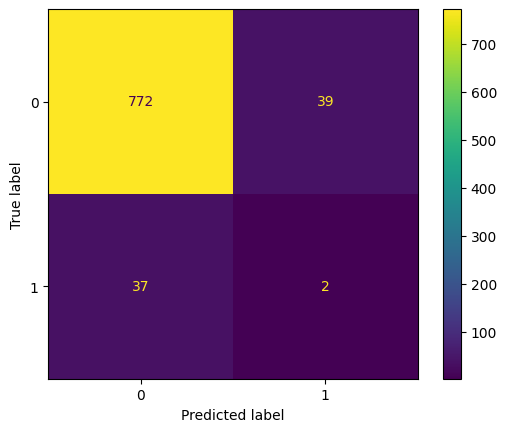

In [49]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(all_labels, all_preds)
ConfusionMatrixDisplay(cm).plot()

In [50]:
from huggingface_hub import login
login()

In [52]:
model.push_to_hub("jorgeortizv/BERT-hateSpeechRecognition-German")

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/jorgeortizv/BERT-hateSpeechRecognition-German/commit/45aef5042ea654f123d27f1f9a7a5b597bf4601a', commit_message='Upload BertForSequenceClassification', commit_description='', oid='45aef5042ea654f123d27f1f9a7a5b597bf4601a', pr_url=None, pr_revision=None, pr_num=None)

In [53]:
tokenizer.push_to_hub("jorgeortizv/BERT-hateSpeechRecognition-German")

CommitInfo(commit_url='https://huggingface.co/jorgeortizv/BERT-hateSpeechRecognition-German/commit/e4c41082f2c31d0b50f94b8991ce8d2a7ccdf337', commit_message='Upload tokenizer', commit_description='', oid='e4c41082f2c31d0b50f94b8991ce8d2a7ccdf337', pr_url=None, pr_revision=None, pr_num=None)